# Programando una red neuronal desde 0

In [419]:
from keras.datasets import mnist
import numpy as np
from math import e
import matplotlib.pyplot as plt
from queue import LifoQueue

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Clase RedNeuronal

Sea $C(a)$ la funcion del coste definida como...
$$C=\frac{1}{2}\sum_i (y_i - a_i)^2$$

Con la funcion de activacion sigmoidea $a(Z^L)$...
$$a(z) = \frac{1}{a+e^{-z}}$$

Para la sumatoria $Z$ de la capa $L$...
$$Z^L = \sum w_i^L x_i^{L-1} + B^L$$

### Forward Propagation:

El output de la L-esima capa es:

$$ out^{L} = a(Z^{L}) = a(W^{L}a^{L-1} + b^{L}) = a(\sum w_i^{L} x_i + b^{L}) $$

Donde $a^{L-1}$ es el output de la capa anterior o, en su defecto, el input.

### Backward Propagation:

Sea $\delta^L$ el error imputado de la neurona:

$$\delta^L = \frac{\partial C}{\partial a} * \frac{\partial a}{\partial Z^L}$$

Vemos el caso de la ultima capa, por regla de la cadena:

$$\frac{\partial C}{\partial W^L} = \delta^L * \frac{\partial Z^L}{\partial W^L} = \delta^L * a^{L-1}$$
$$\frac{\partial C}{\partial B^L} = \delta^L * \frac{\partial Z^L}{\partial B} = \delta^L$$

Y si L es la primer capa $\rightarrow a^{L-1}$ es el input.

Luego, para las capas anteriores:

$$\frac{\partial C}{\partial W^{L-1}} = \delta^L * \frac{\partial Z^L}{\partial a^{L-1}}
 * \frac{\partial a^{L-1}}{\partial Z^{L-1}} * \frac{\partial Z^{L-1}}{\partial W^{L-1}} $$

$$\frac{\partial C}{\partial B^{L-1}} = \frac{\partial Z^L}{\partial a^{L-1}}
 * \frac{\partial a^{L-1}}{\partial Z^{L-1}} * \frac{\partial Z^{L-1}}{\partial B^{L-1}}$$

Y por regla de la cadena queda:

$$\frac{\partial C}{\partial W^{L-1}} = \delta^L * W^L * \frac{\partial a^{L-1}}{\partial z^{L-1}} * a^{L-2} $$

$$\frac{\partial C}{\partial W^{L-1}} = \delta^L * W^L * \frac{\partial a^{L-1}}{\partial z^{L-1}} $$


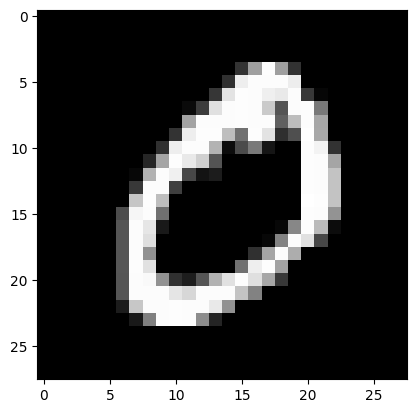

In [247]:
def plot_image(img_matrix: np.ndarray):
    plt.imshow(img_matrix, cmap=plt.get_cmap('gray'))
    plt.show()

plot_image(X_train[1])

In [398]:
class Layer:

    def __init__(self, neurons, input_shape, act="sigmoid"):
        self.neurons = neurons
        self.input_shape = input_shape
        self.weights = np.random.rand(self.input_shape, self.neurons)
        self.bias = np.random.rand(self.neurons)
        self.act = act

def sigmoid(x):
    return 1 / (1 + e ** -x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [451]:
class NeuralNetwork:

    def __init__(self, input_size, layers, output_size):
        # Inicializo la red con los parametros dados
        self.input_size = input_size
        self.layers = layers
        self.output_size = output_size  

    def forward(self, X:np.ndarray, retLayers=False) -> np.ndarray:
        # Dado un input X, devuelve el output de la red   
        J = X
        A = LifoQueue()
        for layer in self.layers:
            J = sigmoid(np.dot(J, layer.weights) + layer.bias)
            A.put(J)
        return A

    def backward(self, X, Y, A, l_rate):
        # Dado un input X y un output Y, actualiza los pesos de la red
        output = A.get()
        error = Y - output
        delta_output = error * sigmoid_derivative(output)

        a = A.get() # output de la capa anterior a la ultima
        d_weights = delta_output.dot(a.weights.T)
        d_bias = delta_output

        # Actualizo los pesos de la ultima capa
        self.layers[-1].weights -= d_weights * l_rate
        self.layers[-1].bias -= d_bias * l_rate

        for layer in enumerate(self.layers[-2::-1]):
            # Calculo el delta de la capa
            delta = d_weights * sigmoid_derivative(a)
            
            d_weights = delta.dot(layer.weights.T)
            d_bias = delta
            
            # Actualizo los pesos de la capa
            layer.weights -= d_weights * l_rate
            layer.bias -= d_bias * l_rate

    def train(self, X, Y, epochs, l_rate): 
        for _ in range(epochs):
            output = self.forward(X)
            self.backward(X, Y, output, l_rate)       
        
    def predict(self, X):
        return self.forward(X).get()

In [452]:
model = NeuralNetwork(
                784,
                [Layer(16, 784),
                 Layer(16, 16),
                 Layer(16, 16),
                 Layer(10, 16)],
                10)

model.predict(np.random.rand(784))

array([0.99993906, 0.99987781, 0.99968674, 0.99966308, 0.99992857,
       0.99983356, 0.9998677 , 0.99874626, 0.99993917, 0.99992379])

### Simulacion Backwards

In [453]:
x = X_train[0].reshape(1, 784)
y = np.zeros(10)
y[0] = 1

model.train([x], [y], 100, 0.1)

ValueError: operands could not be broadcast together with shapes (16,10) (1,1,16) (16,10) 